# Affective categorizaion of images

In [142]:
import tensorflow as tf
from PIL import Image
import glob
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.estimators.classification import TensorFlowV2Classifier
import os

## Load data from Emotion6
source: http://chenlab.ece.cornell.edu/downloads.html

In [143]:
# load data from Emotion6 directiry
def get_images_and_labels(path):
    size = (128, 128)
    all_images = []
    image_names = []
    for filename in glob.glob(path + '*/*'):
        img = cv2.imread(filename)
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        img = np.array(img)
        all_images.append(img.tolist())
        image_names.append(filename.replace(path, ''))
    return np.array(all_images), np.array(image_names)

In [144]:
X, Y = get_images_and_labels(os.getcwd() + ('\\Emotion6\\images\\' if os.name == 'nt' else '/Emotion6/images/'))

In [146]:
valence, arousal = get_v_a_labels(Y, os.getcwd() + '\\Emotion6\\' if os.name == 'nt' else '/Emotion6/')

## Data preprocessing

In [147]:
# nomrmalization
X = X / 255.0

In [148]:
# join valence and arousal into matrix 2 x 2
joinedY = valence * 10 + arousal
for i in range(len(joinedY)):
    if joinedY[i] == 10:
        joinedY[i] = 2
    if joinedY[i] == 11:
        joinedY[i] = 3

In [149]:
# randomly shuffle data
shuffler = np.random.permutation(X.shape[0])

X = X[shuffler]
joinedY = joinedY[shuffler]

In [150]:
# split
X_train, X_test = np.split(X, [int(len(X) * 0.9)])
joinedY_train, joinedY_test = np.split(joinedY, [int(len(joinedY) * 0.9)])

In [151]:
# one-hot encoding
joinedY_train = tf.one_hot(joinedY_train, 4)
joinedY_test = tf.one_hot(joinedY_test, 4)

In [152]:
batch_size = 32
input_shape = (128, 128, 3)

## Inecptionv3
Use pretrained Inecptionv3 model

In [153]:
# load and freeze base model
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [154]:
# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [156]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=15, validation_split=0.3)

Epoch 1/15
39/39 [==============================] - 14s 306ms/step - loss: 0.7237 - acc: 0.3793 - val_loss: 0.6483 - val_acc: 0.3888
Epoch 2/15
39/39 [==============================] - 11s 290ms/step - loss: 0.5931 - acc: 0.4812 - val_loss: 0.6274 - val_acc: 0.3925
Epoch 3/15
39/39 [==============================] - 11s 295ms/step - loss: 0.5133 - acc: 0.5437 - val_loss: 0.6143 - val_acc: 0.4037
Epoch 4/15
39/39 [==============================] - 12s 298ms/step - loss: 0.4532 - acc: 0.5982 - val_loss: 0.6036 - val_acc: 0.4112
Epoch 5/15
39/39 [==============================] - 12s 303ms/step - loss: 0.4084 - acc: 0.6455 - val_loss: 0.6098 - val_acc: 0.4318
Epoch 6/15
39/39 [==============================] - 12s 305ms/step - loss: 0.3710 - acc: 0.6776 - val_loss: 0.6103 - val_acc: 0.4243
Epoch 7/15
39/39 [==============================] - 12s 306ms/step - loss: 0.3480 - acc: 0.7217 - val_loss: 0.6002 - val_acc: 0.4262
Epoch 8/15
39/39 [==============================] - 12s 306ms/step - 

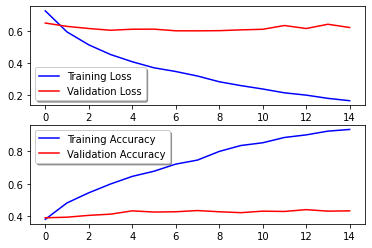

In [157]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [158]:
# test model
test_loss, test_acc = model.evaluate(X_test, joinedY_test)

7/7 [==============================] - 1s 149ms/step - loss: 0.5666 - acc: 0.5101


## Inceptionv3 with full training

In [159]:
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [160]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=25, validation_split=0.3)

Epoch 1/25
39/39 [==============================] - 52s 1s/step - loss: 0.5964 - acc: 0.4122 - val_loss: 0.7060 - val_acc: 0.4206
Epoch 2/25
39/39 [==============================] - 45s 1s/step - loss: 0.5355 - acc: 0.4812 - val_loss: 0.6411 - val_acc: 0.4374
Epoch 3/25
39/39 [==============================] - 46s 1s/step - loss: 0.5020 - acc: 0.4932 - val_loss: 0.5913 - val_acc: 0.4336
Epoch 4/25
39/39 [==============================] - 45s 1s/step - loss: 0.4686 - acc: 0.5461 - val_loss: 0.5564 - val_acc: 0.4187
Epoch 5/25
39/39 [==============================] - 45s 1s/step - loss: 0.4431 - acc: 0.5750 - val_loss: 0.5601 - val_acc: 0.4355
Epoch 6/25
39/39 [==============================] - 45s 1s/step - loss: 0.4160 - acc: 0.6135 - val_loss: 0.5761 - val_acc: 0.4280
Epoch 7/25
39/39 [==============================] - 45s 1s/step - loss: 0.3963 - acc: 0.6207 - val_loss: 0.5687 - val_acc: 0.4411
Epoch 8/25
39/39 [==============================] - 45s 1s/step - loss: 0.3701 - acc: 0.67

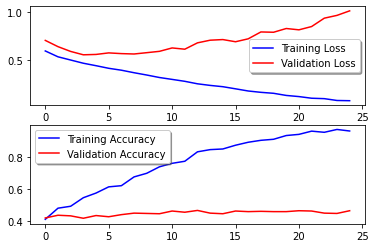

In [161]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [162]:
# test model
test_loss, test_acc = model.evaluate(X_test, joinedY_test)

7/7 [==============================] - 1s 190ms/step - loss: 1.0107 - acc: 0.4444


In [163]:
# save model
model.save('images_model.h5')

## Fast Gradient Sign Method attack

In [164]:
classifier = TensorFlowV2Classifier(
    model          = model,
    nb_classes     = 4,
    input_shape    = X[0].shape,
    loss_object    = tf.keras.losses.get("binary_crossentropy"),
    clip_values    = (0, 1),
    channels_first = False)

In [165]:
def perform_attack(attack, x_data, y_data):
    x_data_adv = attack.generate(x_data)
    
    y_data_predictions = np.argmax(classifier.model(x_data_adv), axis=1)
    accuracy_adv = np.sum(y_data_predictions == np.argmax(y_data)) / len(y_data)

    perturbation = np.mean(np.abs((x_data_adv - x_data)))

    print('Accuracy on adversarial test data: {}'.format(accuracy_adv))
    print('Average perturbation: {}'.format(perturbation))
    
    return x_data_adv, attack

def perform_fgsm_attack(classifier, x_data, y_data):
    attack = FastGradientMethod(estimator=classifier)
    return perform_attack(attack, x_data, y_data)

In [166]:
x_test_adv, attack = perform_fgsm_attack(classifier, X_test, joinedY_test)

Accuracy on adversarial test data: 0.7575757575757576
Average perturbation: 0.2396854383847834


After attack:
Prediction: 3 - 2 - 3:


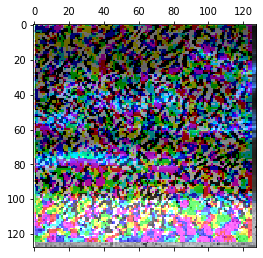

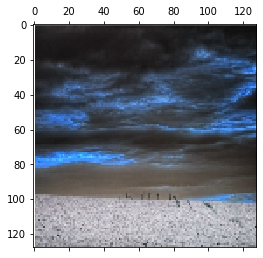

Prediction: 3 - 1 - 2:


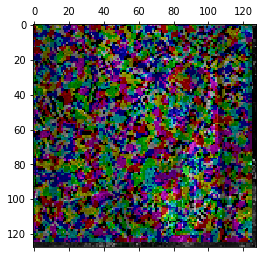

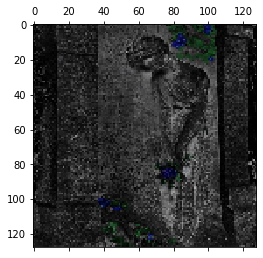

Prediction: 2 - 3 - 2:


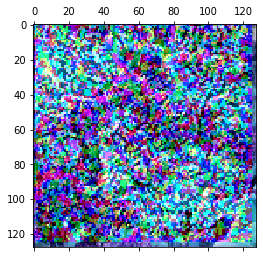

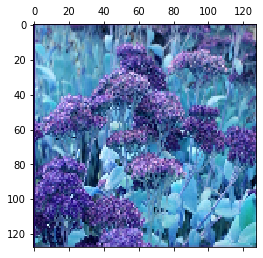

Prediction: 3 - 3 - 1:


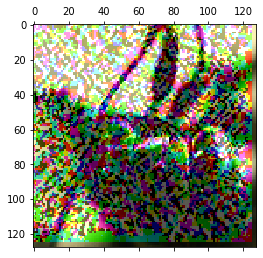

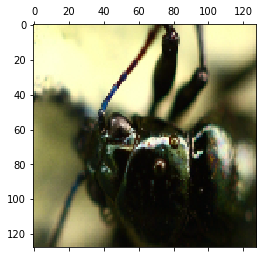

Prediction: 3 - 3 - 0:


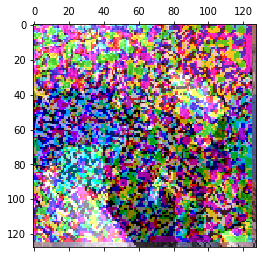

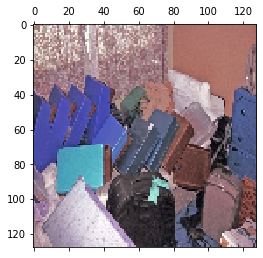

Prediction: 1 - 3 - 1:


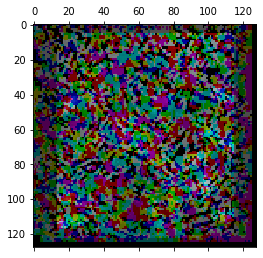

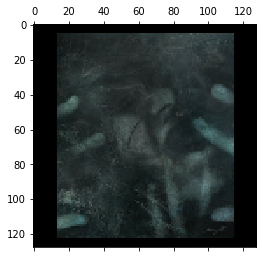

Prediction: 3 - 3 - 3:


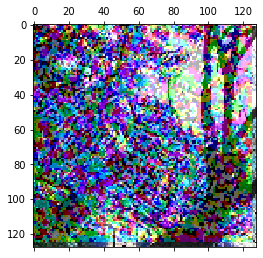

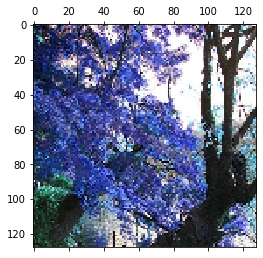

Prediction: 3 - 0 - 3:


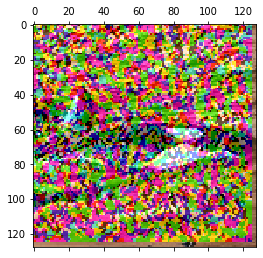

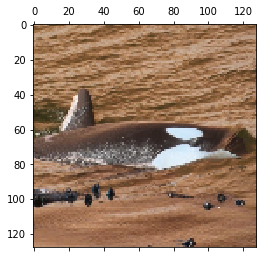

In [167]:
print('After attack:')

for i in range(8):
    prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[i]])), axis=1)[0]
    prediction_model = np.argmax(classifier.model.predict(np.array([X_test[i]])), axis=1)[0]
    expected_y = np.argmax(joinedY_test[i])
    print('Prediction: after: {} - before: {} - expected: {}:'.format(prediction, prediction_model, expected_y))

    plt.matshow(x_test_adv[i])
    plt.matshow(X_test[i])
    plt.show()

## Carlini & Wagner Infinity-norm attack

In [168]:
def perform_carlini_wagner_attack(classifier, x_data, y_data):
    attack = CarliniLInfMethod(classifier=classifier, 
                               max_iter=1, 
                               learning_rate=0.1, 
                               initial_const=1e0, 
                               largest_const=2e0)
    return perform_attack(attack, x_data, y_data)

In [169]:
x_test_adv, attack = perform_carlini_wagner_attack(classifier, X_test, joinedY_test)

C&W L_inf:   0%|          | 0/198 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.47474747474747475
Average perturbation: 0.018165838381853195


After attack:
Prediction: 3 - 2 - 3:


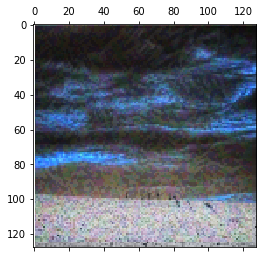

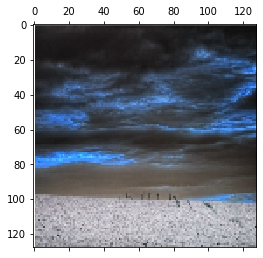

Prediction: 3 - 1 - 2:


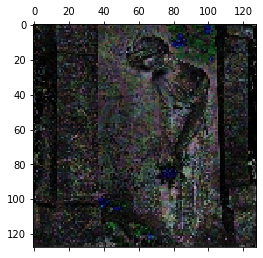

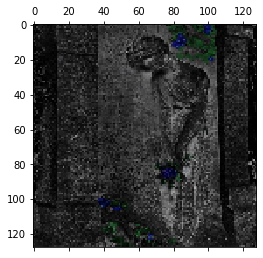

Prediction: 3 - 3 - 2:


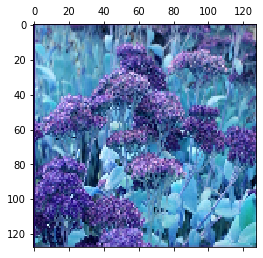

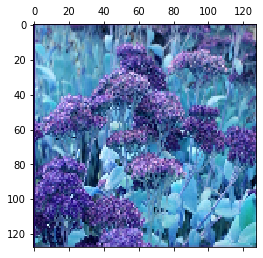

Prediction: 3 - 3 - 1:


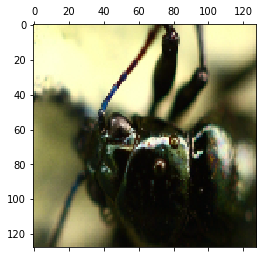

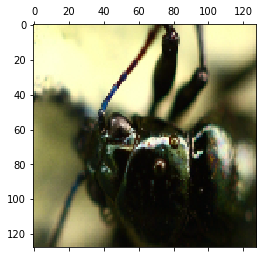

Prediction: 1 - 3 - 0:


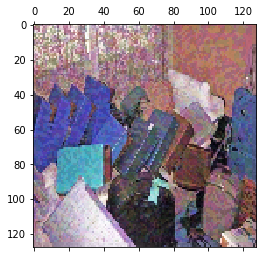

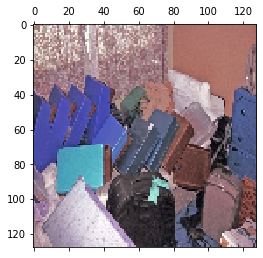

Prediction: 1 - 3 - 1:


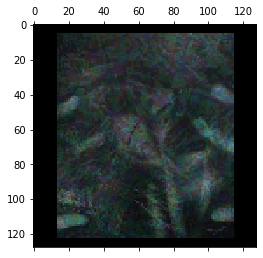

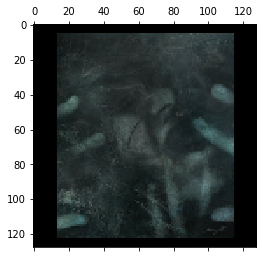

Prediction: 3 - 3 - 3:


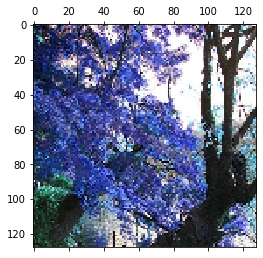

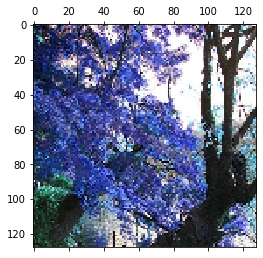

Prediction: 3 - 0 - 3:


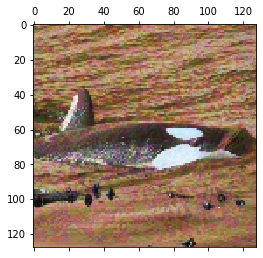

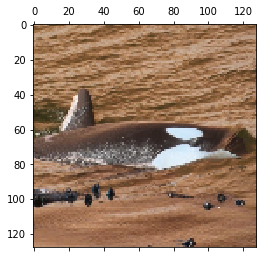

In [170]:
print('After attack:')

for i in range(8):
    prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[i]])), axis=1)[0]
    prediction_model = np.argmax(classifier.model.predict(np.array([X_test[i]])), axis=1)[0]
    expected_y = np.argmax(joinedY_test[i])
    print('Prediction: after: {} - before: {} - expected: {}:'.format(prediction, prediction_model, expected_y))

    plt.matshow(x_test_adv[i])
    plt.matshow(X_test[i])
    plt.show()

